# Face Aging

Mit diesem Jupyter-Notebook könnt ihr die trainierten Gewichte des PFA-GANs laden und dann euer eigenes Bild altern lassen. Dafür müsst ihr einfach die Variable `your_image_path` in der jeweiligen Zelle anpassen, wo ihr euer Bild gespeichert habt, das ihr durch das Netzwerk ändern lassen wollt.

# Imports

In [91]:
from torch import nn, Tensor, zeros, sum as tsum
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets.folder import pil_loader

import os
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## PFA-GAN

### Generator

In [93]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.n_channels = channels
        self._init_model()
    
    def _init_model(self):
        layers = [
            nn.Conv2d(
                self.n_channels,
                self.n_channels,
                3,
                1,
                1
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                self.n_channels,
                self.n_channels,
                3,
                1,
                1
            ),
            nn.BatchNorm2d(self.n_channels),
        ]

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        x = self.main(x)
        return F.leaky_relu(residual + x, 0.2, inplace=True)

In [94]:
class GeneratorSubNetwork(nn.Module):
    def __init__(self, in_channels=3, n_residual_blocks=4):
        super(GeneratorSubNetwork, self).__init__()

        self.in_channels = in_channels
        self.n_residual_blocks = n_residual_blocks

        self._init_model()
    
    def _init_model(self):
        layers = [
            nn.Conv2d(
                in_channels=self.in_channels,
                out_channels=32,
                kernel_size=9,
                stride=1,
                padding=4
            ),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        for _ in range(self.n_residual_blocks):
            layers.append(ResidualBlock(128))

        layers.extend([
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=32,
                out_channels=3,
                kernel_size=9,
                stride=1,
                padding=4
            )
        ])
    
        self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x)

In [95]:
class Generator(nn.Module):
    def __init__(self, age_group, n_residual_blocks=4):
        super(Generator, self).__init__()
        self.age_group = age_group
        self._init_model(n_residual_blocks)
    
    def _init_model(self, n_residual_blocks):
        self.sub_networks = nn.ModuleList()

        for _ in range(self.age_group - 1):
            self.sub_networks.append(GeneratorSubNetwork(
                in_channels=3,
                n_residual_blocks=n_residual_blocks
            ))
    
    def forward(self, x, source_label: Tensor, target_label: Tensor):
        condition = self._pfa_encoding(source_label, target_label, self.age_group).to(device)
        for i in range(self.age_group - 1):
            aging_effects = self.sub_networks[i](x)
            x = x + aging_effects * condition[:, i]
        return x

    def _pfa_encoding(self, source, target, age_group):
        source, target = source.long(), target.long()
        code = zeros((source.size(0), age_group - 1, 1, 1, 1)).to(source)
        for i in range(source.size(0)):
            code[i, source[i]: target[i], ...] = 1
        return code

### PFA-GAN

In [96]:
class FaceAging:
    def __init__(self, age_group=4, experiment=0, checkpoint=0):
        self.experiment = experiment
        self.checkpoint = checkpoint

        self.generator = Generator(age_group)
        checkpoint = torch.load(
            os.path.join(
                'model',
                'pfa-gan',
                'checkpoint',
                f'exp_{self.experiment}',
                f'pfa-gan_{self.checkpoint}.obj'
            )
        )
        self.generator.load_state_dict(checkpoint['generator_state_dict'])
        self.generator.cuda()
        self.generator.eval()
    
    def generate(self, img):
        image_path, image_filename = os.path.split('./test/test/43849636.jpg')

        image = pil_loader(img).resize((248,248))
        image = transforms.ToTensor()(image)
        images = image[None,:].to(device=device)

        grid_img = self._generate_images(images)

        self._save_image(
            grid_img,
            os.path.join(
                'test',
                'face-aging',
                f'checkpoint_{self.checkpoint}'
            ),
            f'{image_filename}'
        )

        return grid_img
    
    @torch.no_grad()
    def _generate_images(self, images, n_source=0, age_group=4):
        real_img = images.to(device)
        bs, ch, w, h = real_img.size()
        fake_imgs = [real_img, ]

        for target in range(n_source + 1, age_group):
            output = self.generator(real_img, torch.ones(bs) * n_source, torch.ones(bs) * target)
            fake_imgs.append(output)
            
        fake_imgs = torch.stack(fake_imgs).transpose(1, 0).reshape((-1, ch, w, h))

        fake_imgs = fake_imgs * 0.5 + 0.5

        return torchvision.utils.make_grid(fake_imgs.clamp(0., 1.), nrow=age_group - n_source)

    def _save_image(self, grid_img, path, img_name):
        if not os.path.exists(path):
            os.makedirs(path)
        
        save_image(
            grid_img,
            os.path.join(path, img_name),
            nrow=1
        )

In [97]:
face_aging = FaceAging(
    experiment=15,
    checkpoint=125000
)

In [ ]:
your_image_path = ''

In [98]:
image = face_aging.generate(your_image_path)

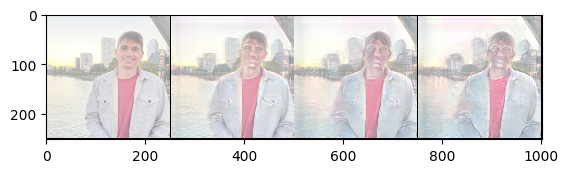

In [99]:
plt.imshow(np.transpose(image.cpu().numpy(), (1,2,0)), interpolation='nearest')